# Step 1 - Import libraries

In [1]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
import hvplot.pandas
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt

from yahoo_fin.stock_info import *
import yfinance as yf

import vectorbt as vbt

plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# Step 2 - Extracting Data

In [2]:
# Import ticker data from yahoo finance
stocks = ["AAPL", "MSFT", "CBA.AX"]

stocks_df = yf.download(tickers = stocks, start = "2015-01-01", end = "2019-01-01", interval = "1d", group_by = "ticker")
stocks_df.head()

[*********************100%***********************]  3 of 3 completed


CBA.AX                                                         \
                 Open       High        Low      Close  Adj Close     Volume   
Date                                                                           
2014-12-31        NaN        NaN        NaN        NaN        NaN        NaN   
2015-01-02  84.959686  85.277962  84.661308  85.277962  61.523941   949439.0   
2015-01-05  85.238182  85.775269  85.049202  85.486832  61.674625  1351651.0   
2015-01-06  84.641411  85.337639  84.412651  84.840332  61.208210  2477275.0   
2015-01-07  84.850281  85.029312  84.094376  84.651360  61.071877  2127190.0   

                 AAPL                                              \
                 Open       High        Low      Close  Adj Close   
Date                                                                
2014-12-31  28.205000  28.282499  27.552500  27.594999  25.057606   
2015-01-02  27.847500  27.860001  26.837500  27.332500  24.819241   
2015-01-05  27.072500  27.162500  26.352501  26.562500  24.120045   
2015-01-06  26.635000  26.857500  26.157499  26.565001  24.122320   
2015-01-07  26.799999  27.049999  26.674999  26.937500  24.460564   

                              MSFT                                   \
                 Volume       Open       High        Low      Close   
Date                                                                  
2014-12-31  165613600.0  46.730000  47.439999  46.450001  46.450001   
2015-01-02  212818400.0  46.660000  47.419998  46.540001  46.759998   
2015-01-05  257142000.0  46.369999  46.730000  46.250000  46.330002   
2015-01-06  263188400.0  46.380001  46.750000  45.540001  45.650002   
2015-01-07  160423600.0  45.980000  46.459999  45.490002  46.230000   

                                   
            Adj Close      Volume  
Date                               
2014-12-31  41.074078  21552500.0  
2015-01-02  41.348206  27913900.0  
2015-01-05  40.967976  39673900.0  
2015-01-06  40.366688  36447900.0  
2015-01-07  40.879539  29114100.0

# Step 3 - MACD calculation

In [3]:
# Calculate MACD data and add to dictionary
macd_list = {}
for stock in stocks:
    # MACD data
    ewm_fast = stocks_df[stock, "Close"].ewm(span = 12, adjust = False).mean()
    ewm_slow = stocks_df[stock, "Close"].ewm(span = 26, adjust = False).mean()
    macd = pd.DataFrame(ewm_fast - ewm_slow)
    macd = macd.rename(columns = {"Close":"macd"})
    # Signal data
    signal = pd.DataFrame(macd[stock, "macd"].ewm(span = 9, adjust = False).mean()).rename(columns = {"macd":"signal"})
    # Histogram data
    histogram = pd.DataFrame(macd[stock, "macd"] - signal[stock, "signal"]).rename(columns = {0:(stock, "hist")})
    ticker_macd = pd.concat([macd, signal, histogram], join = "inner", axis = 1)
    macd_list[stock] = ticker_macd

# Step 4 - Plot MACD data

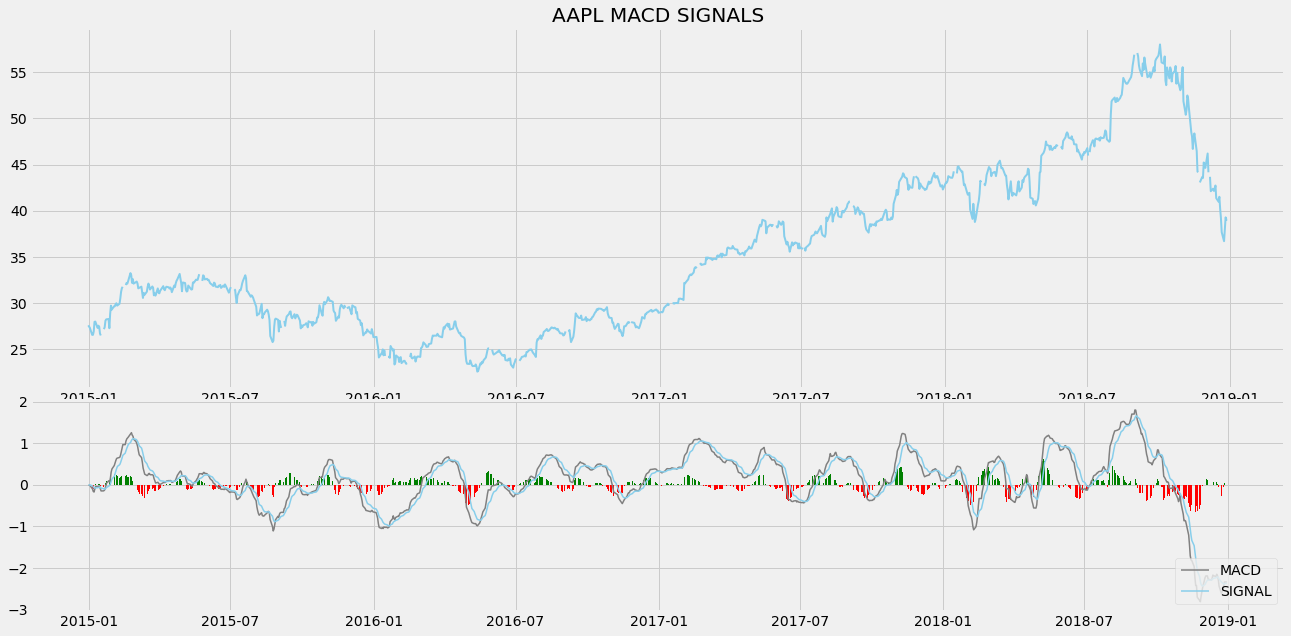

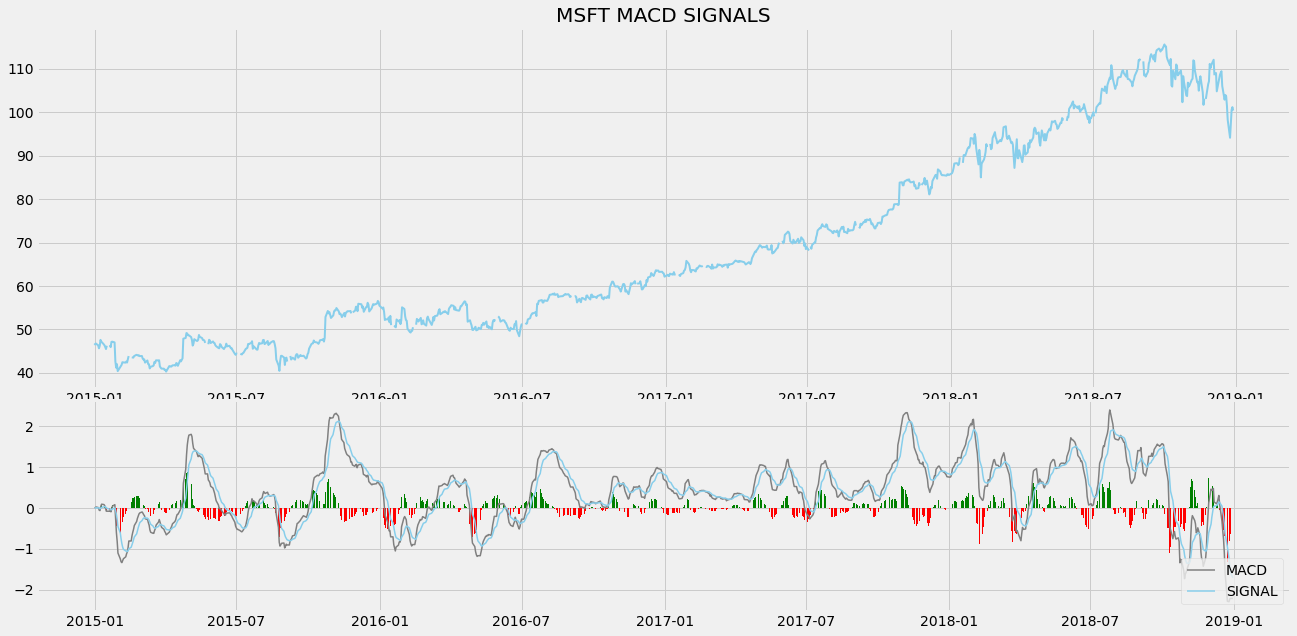

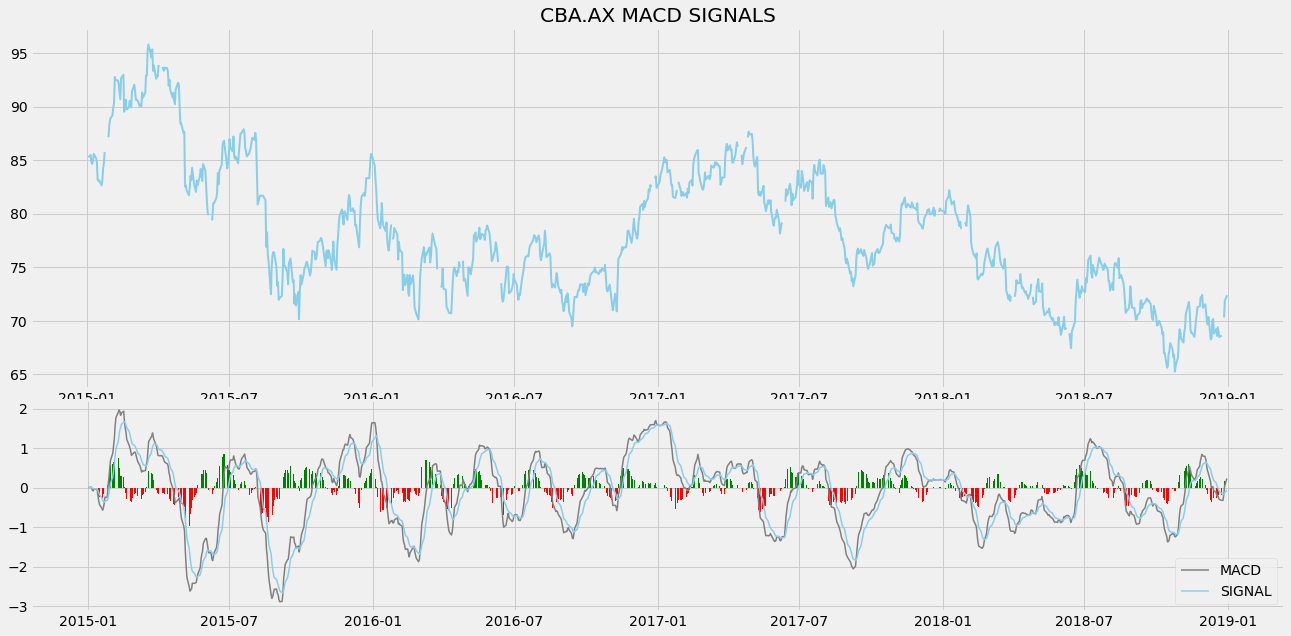

In [4]:
# Plot MACD data per individual stock
for stock in stocks:            
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(stocks_df[stock]["Close"], color = 'skyblue', linewidth = 2, label = stock)
    
    ax1.set_title(f'{stock} MACD SIGNALS')
    ax2.plot(macd_list[stock][stock]['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(macd_list[stock][stock]['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(macd_list[stock][stock])):
        if str(macd_list[stock][stock]['hist'][i])[0] == '-':
            ax2.bar(macd_list[stock][stock].index[i], macd_list[stock][stock]['hist'][i], color = 'red')
        else:
            ax2.bar(macd_list[stock][stock].index[i], macd_list[stock][stock]['hist'][i], color = 'green')
    
    plt.legend(loc = 'lower right')
    plt.show()

# Step 5 - Create the Trading strategy

In [4]:
# Create Trading Strategy function
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    # For loop for range of dates
    for i in range(len(data)):
        # Conditional produce signal to buy stock
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        # Conditional produce signal to sell stock
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

# Step 6 - Plotting the Trading lists

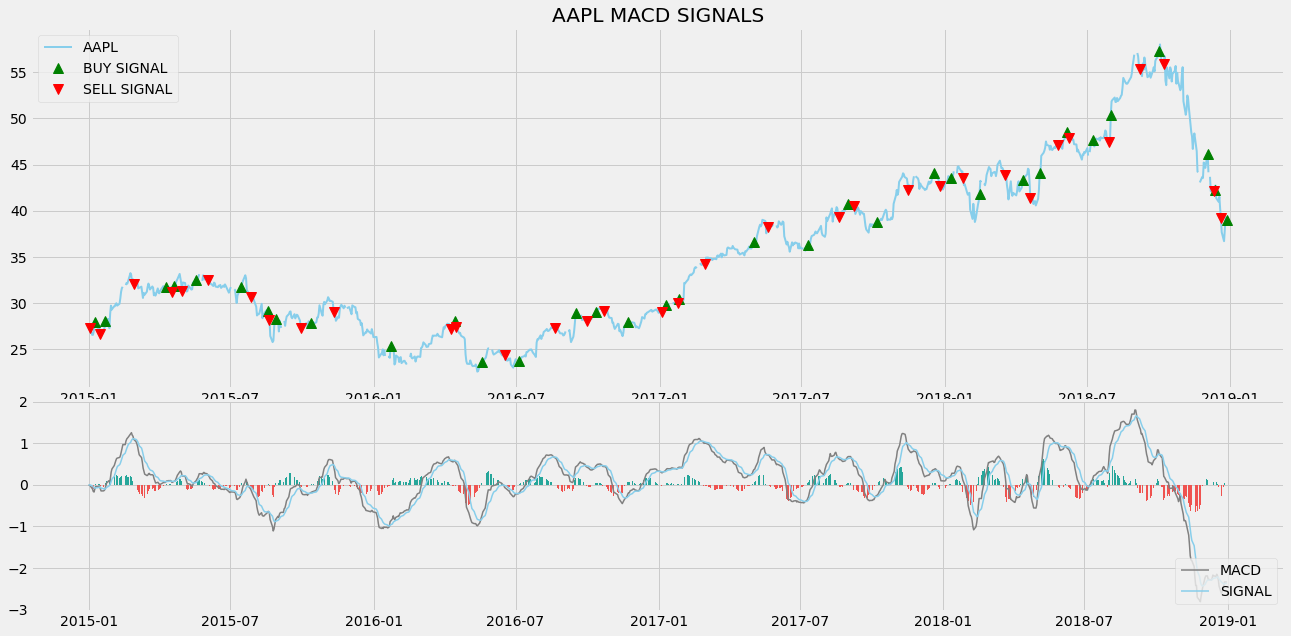

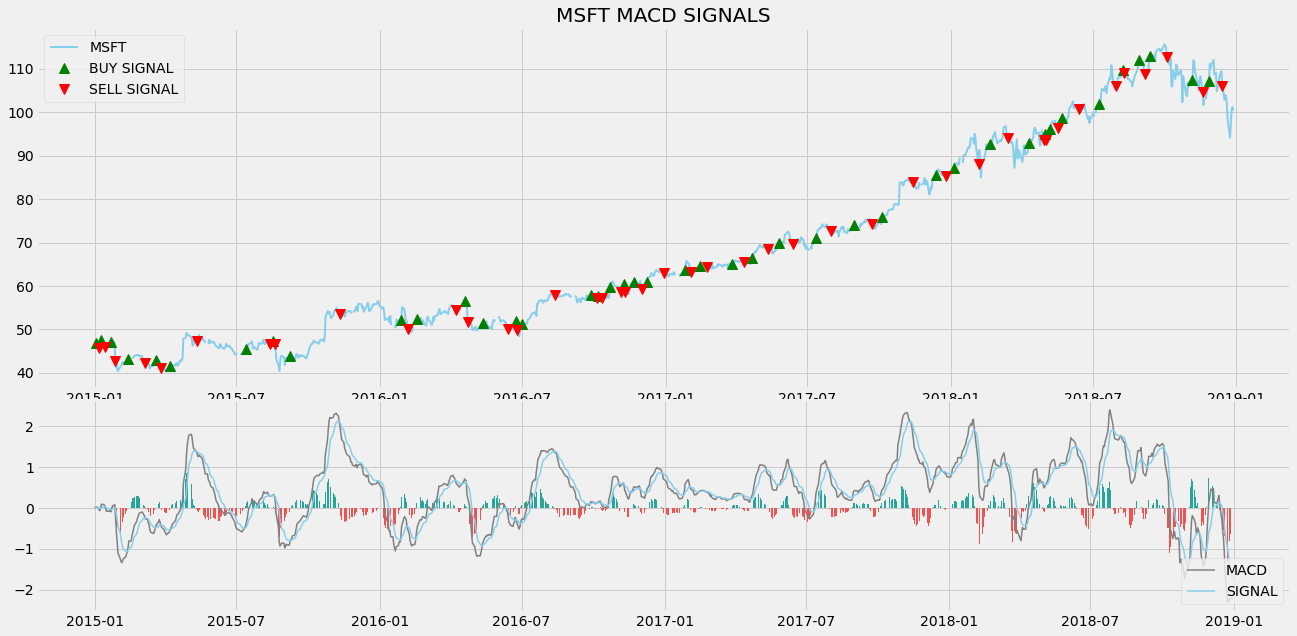

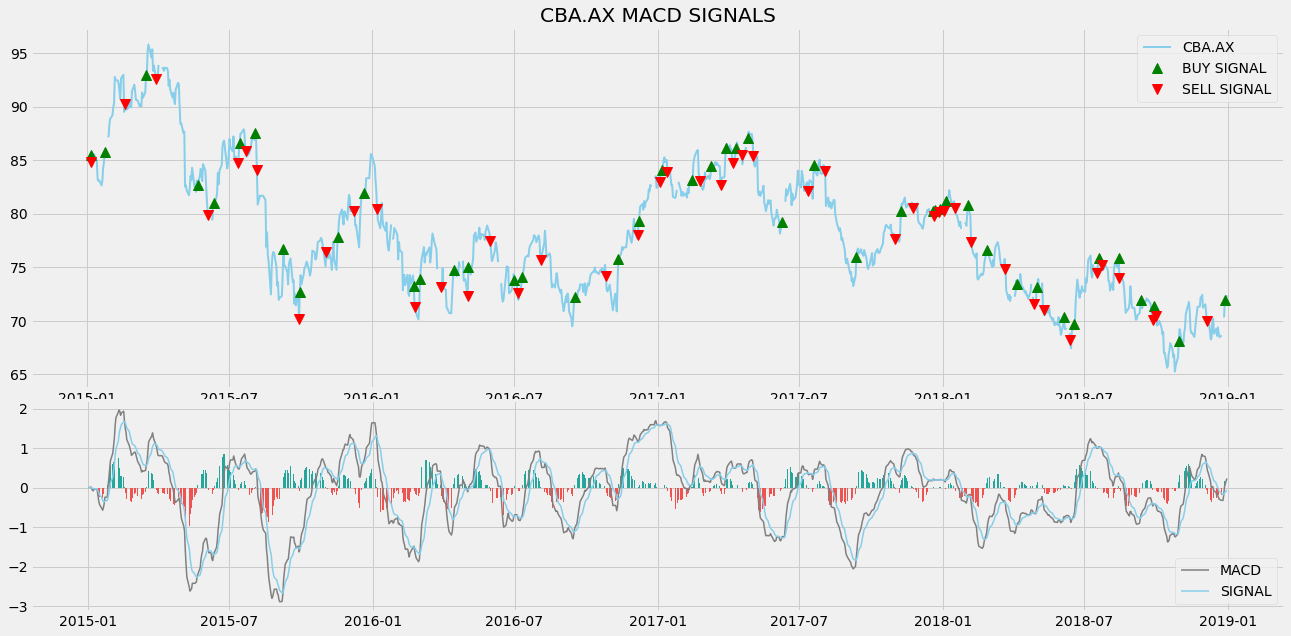

In [5]:
# Run trade strategy and plot buy and sell signals
for stock in stocks:            
    buy_price, sell_price, macd_signal = implement_macd_strategy(stocks_df[stock]["Close"], macd_list[stock][stock])

    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(stocks_df[stock]["Close"], color = 'skyblue', linewidth = 2, label = stock)
    ax1.plot(stocks_df[stock]["Close"].index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
    ax1.plot(stocks_df[stock]["Close"].index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
    ax1.legend()
    ax1.set_title(f'{stock} MACD SIGNALS')
    ax2.plot(macd_list[stock][stock]['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(macd_list[stock][stock]['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(macd_list[stock][stock])):
        if str(macd_list[stock][stock]['hist'][i])[0] == '-':
            ax2.bar(macd_list[stock][stock].index[i], macd_list[stock][stock]['hist'][i], color = '#ef5350')
        else:
            ax2.bar(macd_list[stock][stock].index[i], macd_list[stock][stock]['hist'][i], color = '#26a69a')
        
    plt.legend(loc = 'lower right')
    plt.show()

# Step 7 - Create position on stock

In [6]:
# Run strategy to create position
stock_strategy = {}

for stock in stocks:            
    buy_price, sell_price, macd_signal = implement_macd_strategy(stocks_df[stock]["Close"], macd_list[stock][stock])

    position = []
    for i in range(len(macd_signal)):
        if macd_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)
            
    for i in range(len(stocks_df[stock]['Close'])):
        if macd_signal[i] == 1:
            position[i] = 1
        elif macd_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
            
    macd = macd_list[stock][stock]['macd']
    signal = macd_list[stock][stock]['signal']
    close_price = stocks_df[stock]["Close"]
    macd_signal = pd.DataFrame(macd_signal).rename(columns = {0:'macd_signal'}).set_index(stocks_df[stock]["Close"].index)
    position = pd.DataFrame(position).rename(columns = {0:'macd_position'}).set_index(stocks_df[stock]["Close"].index)

    frames = [close_price, macd, signal, macd_signal, position]
    strategy = pd.concat(frames, join = 'inner', axis = 1)

    stock_strategy[stock] = strategy

In [8]:
# Select stock to display position
stock_strategy["AAPL"]

Close      macd    signal  macd_signal  macd_position
Date                                                                 
2014-12-31  27.594999  0.000000  0.000000            0              1
2015-01-02  27.332500 -0.020940 -0.004188           -1              0
2015-01-05  26.562500 -0.098532 -0.023057            0              0
2015-01-06  26.565001 -0.158001 -0.050046            0              0
2015-01-07  26.937500 -0.173078 -0.074652            0              0
...               ...       ...       ...          ...            ...
2018-12-24  36.707500 -2.611921 -2.335768            0              0
2018-12-26  39.292500 -2.514822 -2.371579            0              0
2018-12-27  39.037498 -2.430430 -2.383349            0              0
2018-12-28  39.057499 -2.335019 -2.373683            1              1
2018-12-31        NaN -2.335019 -2.365950            0              1

[1032 rows x 5 columns]

In [67]:
# Create list and populate according to macd_signal
entries = []
exits = []
for sig in stock_strategy["AAPL"]["macd_signal"]:
    if sig == -1:
        entries.append("False")
        exits.append("True")
    elif sig == 1:
        entries.append("True")
        exits.append("False")
    else:
        entries.append("False")
        exits.append("False")
entries = pd.Series(entries, index = stocks_df["AAPL"]["Close"].index)
exits = pd.Series(exits, index = stocks_df["AAPL"]["Close"].index)
# Change type to bool
entries = entries == "True"
exits = exits == "True"

# Step 8 - Backtesting

In [ ]:
# Individual stock close price
price = stocks_df["AAPL"]["Close"]

In [58]:
# Produce total profit earned from holding stock
portfolio = vbt.Portfolio.from_holding(price, init_cash = 100)
portfolio.total_profit()

41.53832181102118

In [68]:
# Build portfolio using macd signals
portfolio = vbt.Portfolio.from_signals(price, entries, exits, init_cash = 100)

# Produce total profit earned from using MACD signals for trades
portfolio.total_profit()

58.93994267816548

In [ ]:
investment_amount = input()

In [ ]:
googl_ret = pd.DataFrame(np.diff(googl['close'])).rename(columns = {0:'returns'})
macd_strategy_ret = []

for i in range(len(googl_ret)):
    try:
        returns = googl_ret['returns'][i]*strategy['macd_position'][i]
        macd_strategy_ret.append(returns)
    except:
        pass
    
macd_strategy_ret_df = pd.DataFrame(macd_strategy_ret).rename(columns = {0:'macd_returns'})

investment_value = 100000
number_of_stocks = floor(investment_value/googl['close'][-1])
macd_investment_ret = []

for i in range(len(macd_strategy_ret_df['macd_returns'])):
    returns = number_of_stocks*macd_strategy_ret_df['macd_returns'][i]
    macd_investment_ret.append(returns)

macd_investment_ret_df = pd.DataFrame(macd_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(macd_investment_ret_df['investment_returns']), 2)
profit_percentage = floor((total_investment_ret/investment_value)*100)
print(cl('Profit gained from the MACD strategy by investing $100k in GOOGL : {}'.format(total_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the MACD strategy : {}%'.format(profit_percentage), attrs = ['bold']))

In [ ]:
ticker_ret